# Медианные фильтры

In [1]:
import numpy as np
from PIL import Image

## Подготовка

In [58]:
# Загрузим тестовое изображение и представим его в виде np.array
image = Image.open("samples/Original.bmp")
image = np.array(image)

# Для ускорения проверки обрежем исходное изображение
SMALLER_SIZE = 100
image = image[:SMALLER_SIZE, :SMALLER_SIZE, :]

In [59]:
# Будем работать с фильтрами радиуса R
R = 25

# Соответствующий фильтр будет иметь размер FILTER_SIZE
FILTER_SIZE = 2 * R + 1

## Реализации

В данном блоке будут рассмотрены различные реализации медианных фильтров, а затем будет приведено их сравнение

### OpenCV: medianBlur

В библиотеке OpenCV уже присутствует реализация медианного фильтра, возьмём её в качестве эталона для проверки самописных алгоритмов

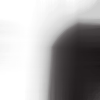

In [60]:
import cv2

blurred_etalon = cv2.medianBlur(image, FILTER_SIZE)

# Посмотрим на результат
Image.fromarray(blurred_etalon)

### Наивный алгоритм

Наивный алгоритм заключается в том, что мы для каждого окна фильтра ищем медиану путём сортировки яркостей пикселей

In [5]:
from algorithms import NaiveMedianFilter

blurred_naive = NaiveMedianFilter().apply(image, R)

100%|██████████| 500/500 [00:32<00:00, 15.38it/s]


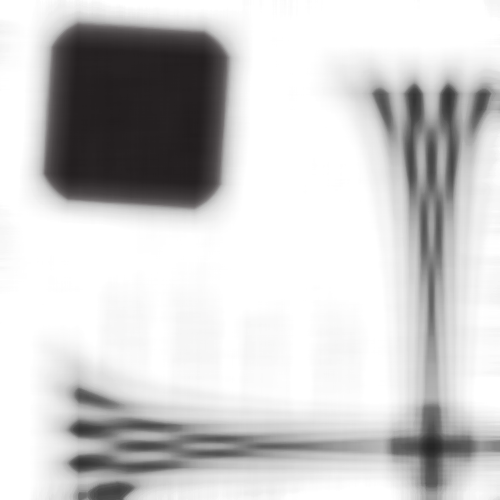

In [6]:
# Посмотрим на результат
Image.fromarray(blurred_naive)

In [7]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_naive))
print("Результаты работы алгоритмов совпадают")

Результаты работы алгоритмов совпадают


### Huang et al., "A Fast Two-Dimensional Median Filtering Algorithm"

Ссылка на оригинальную статью: https://www.uio.no/studier/emner/matnat/ifi/INF2310/v20/undervisningsmateriale/litteratur/huang-etal-median.pdf

Идея алгоритма состоит в использовании гистограммы значений в текущем окне фильтра для быстрого нахождения медианы

In [8]:
from algorithms import HuangMedianFilter

blurred_huang = HuangMedianFilter().apply(image, R)

100%|██████████| 500/500 [01:22<00:00,  6.04it/s]


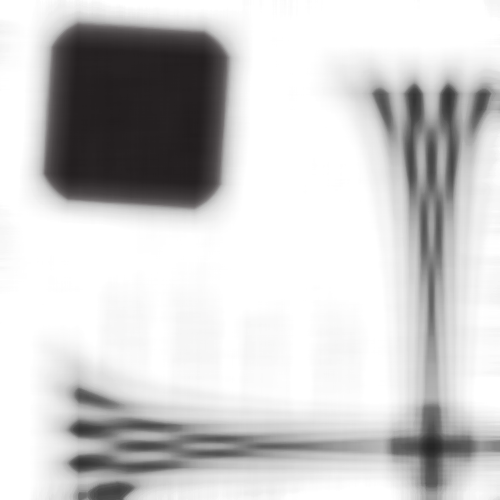

In [9]:
# Посмотрим на результат
Image.fromarray(blurred_huang)

In [10]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_huang))
print("Результаты работы алгоритмов совпадают")

Результаты работы алгоритмов совпадают


### Constant Time

In [191]:
import numpy as np

from algorithms.common import MedianFilter

def get_median(kernel_hist, filter_size):
    median = 0
    less_than_median = 0
    
    threshold = (filter_size ** 2) // 2
    
    while less_than_median + kernel_hist[median] <= threshold:
        less_than_median += kernel_hist[median]
        median += 1

    return median

class ConstantTimeMedianFilter(MedianFilter):
    def __init__(self):
        pass

    def apply(self, image: np.array, radius: int) -> np.array:
        """
        TODO:
        Apply Huang median filter of chosen radius to the image
        Based on original paper: Huang et al., "A Fast Two-Dimensional Median Filtering Algorithm"

        Args:
            image: image represented as numpy array
            radius: filter radius
        Returns:
            image after filter application
        """

        # Array dimensions
        height, width, channels = image.shape
        filter_size = 2 * radius + 1

        # We need to pad image before using filter
        padded_image = self.pad_image(image, radius)
        
        padded_height = height + 2 * radius
        padded_width = width + 2 * radius

        # Blurred image (filled below)
        blurred_image = np.zeros_like(image)

        # Threshold for median identification
        threshold = (filter_size ** 2) // 2
        
        for channel in range(channels):
            column_hists = np.zeros((padded_width, 256), dtype=int)
            updated_column_hists = np.zeros((padded_width, 256), dtype=int)

            # Initialize column histograms
            for j_ in range(padded_width):
                for i_ in range(filter_size):
                    value = padded_image[i_, j_, channel]
                    column_hists[j_, value] += 1
                    updated_column_hists[j_, value] += 1

            for i in range(height):
                for j in range(width):
                    if j == 0:
                        column_hists = updated_column_hists.copy()

                        # Initialize kernel histogram
                        kernel_hist = np.zeros(256, dtype=int)
                        for j_ in range(filter_size):
                            kernel_hist += column_hists[j_]

                            if i + 1 != height:
                                # Remove old value
                                value = padded_image[i, j_, channel]
                                updated_column_hists[j_, value] -= 1

                                # Add new value
                                value = padded_image[i+filter_size, j_, channel]
                                updated_column_hists[j_, value] += 1

                    median = get_median(kernel_hist, filter_size)
                    blurred_image[i, j, channel] = median

                    if i + 1 != width and j + 1 != width:
                        # Remove old value
                        value = padded_image[i, j+filter_size, channel]
                        updated_column_hists[j+filter_size, value] -= 1

                        # Add new value
                        value = padded_image[i+filter_size, j+filter_size, channel]
                        updated_column_hists[j+filter_size, value] += 1

                    if j + 1 != width:
                        # Update kernel histogram
                        kernel_hist += column_hists[j+filter_size]
                        kernel_hist -= column_hists[j]

        return blurred_image

In [192]:
blurred_constant_time = ConstantTimeMedianFilter().apply(image, R)

Channel:   0%|          | 0/3 [00:00<?, ?it/s]

Row:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Row:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Row:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

Column:   0%|          | 0/100 [00:00<?, ?it/s]

In [175]:
# Проверим, что результат работы алгоритма совпал с эталоном
assert np.all(np.equal(blurred_etalon, blurred_constant_time))
print("Результаты работы алгоритмов совпадают")

Результаты работы алгоритмов совпадают


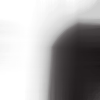

In [176]:
Image.fromarray(blurred_constant_time)

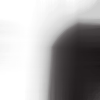

In [164]:
Image.fromarray(blurred_etalon)